We are now going to build our neural network with three convolutional layers. Because none of the functions in the previous section assume anything about the model form, we’ll be able to use them to train a CNN without any modification.

We will use Pytorch’s predefined Conv2d class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling. (Note that view is PyTorch’s version of numpy’s reshape)

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


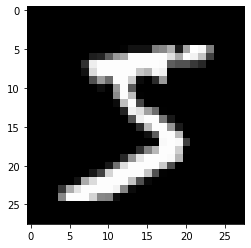

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice. Then create a DataLoader object to make easier the batch management.

In [4]:
import torch

from torch.utils.data import TensorDataset, DataLoader

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

train_ds = TensorDataset(x_train, y_train)
bs=64
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)
n, c = train_ds[:][0].shape
print(x_train, y_train)
print(x_train.shape)

print(train_ds[:][1].unique())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


## NN using torch.nn.functional and torch.nn.Linear

1) Define tensors of random numbers that will become the parameters of the models.
Indicate that those tensors need a Gradient.
Use of Xavier init.

Any parameter used in a model must have the property requires_grad=True in order to update its values with backprop.

Defining model and activation function

The model is just the output layer.

Log softmax (for numerical stability):
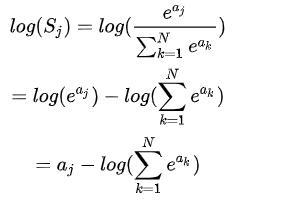

We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s nn classes to make it more concise and flexible. At each step from here, we should be making our code one or more of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from torch.nn.functional (which is generally imported into the namespace F by convention). This module contains all the functions in the torch.nn library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we’ll see, these are usually better handled using other parts of the library.)

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.

On the differences between negative log likelihood, cross entropy loss and KL divergence https://glassboxmedicine.com/2019/12/07/connections-log-likelihood-cross-entropy-kl-divergence-logistic-regression-and-neural-networks/]
Spoiler: They can be the same but their origin has different interpretations

In [5]:
xb, yb = train_ds[:bs]
print(xb.shape)
print(yb.shape)

torch.Size([64, 784])
torch.Size([64])


In [6]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1) # Take the index of the greatest value
    return (preds==yb).float().mean()

import torch.nn.functional as F

loss_func = F.cross_entropy # Combines the softmax with the cross entropy loss.

### Refactoring the model creation using conv2d and relu

Change the model in order to be a convolutional NN.
Convolutions operate in the channels dimension.
Remember that channels=filters=neurons.
Input image are grey scale => 1 input channel.
Convolutions modify the image size (pooling operations also by using the same formula):
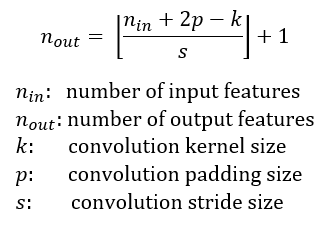

Other formulas:
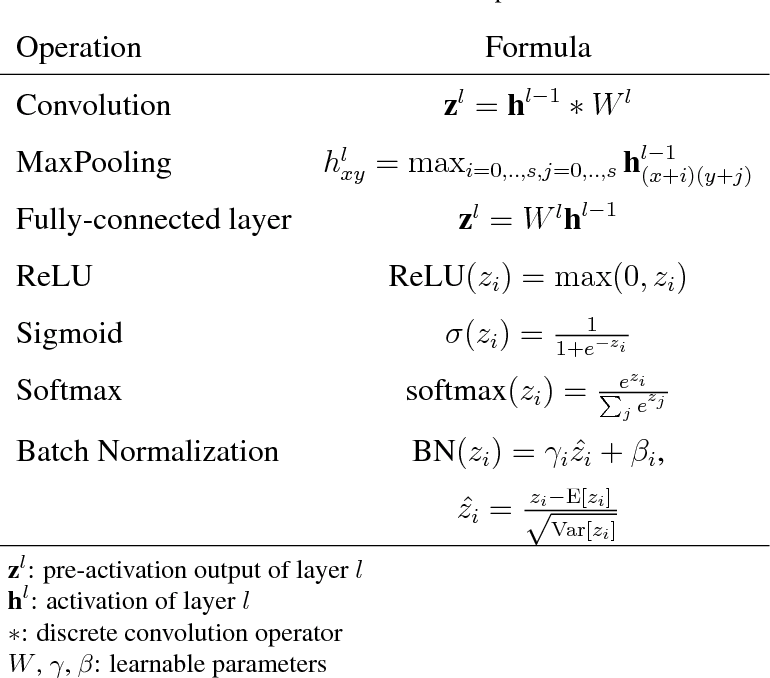

In [37]:
from torch import nn

class Mnist_CNN(nn.Module):
    def __init__(self):
        # In the init method of the class we can define parameters, layers or other components of the model.
        super().__init__()
        #image size: 28*28
        # (Input height + 2p - kernel height) / (stride height) + 1.
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1) # in channel is one (grey images), out channel is 16 (16 neurons or filter declared in the layer)
        # image size 14
        self.conv2 = nn.Conv2d(16,16,kernel_size=3,stride=2,padding=1) # in channel is one (grey images), out channel is 16 (16 neurons or filter declared in the layer)
        # image size 7
        self.conv3 = nn.Conv2d(16,10,kernel_size=3,stride=2,padding=1) # in channel is one (grey images), out channel is 16 (16 neurons or filter declared in the layer)
        # image size 4
        
        #image size:
    def forward(self, xb):
        # In the forward method we define the m2del operations and their order
        #print(xb.shape)   
        # First reshape the input
        xb = xb.view(-1,1,28,28) #add channel dimension and divide the 784 pixels (28x28)
        #print(xb.shape)

        
        # Use conv layers followed by activation function relu
        xb = F.relu(self.conv1(xb))
        #print(xb.shape)
        xb = F.relu(self.conv2(xb))
        #print(xb.shape)
        xb = F.relu(self.conv3(xb))
        #print(xb.shape)
        # Perform max pooling operation
        xb = F.avg_pool2d(xb, 4)
        # Image size is 1
        #print(xb.shape)
        #print("View vs squeeze the output is the same?")
        #print(xb.view(-1,xb.size(1)).shape == xb.squeeze().shape)
        return xb.view(-1,xb.size(1)) # maintain batch dimension, remove the last two dimensions (they are size 1 and 1)
        

In [38]:
test_model_data = torch.randn((64,784))
testing_model = Mnist_CNN()
testing_model(test_model_data).shape

torch.Size([64, 10])

Creating the model (now is an object of the class Mnist_Logistic instead of a function):

#### Refactor of the training loop using optim methods

We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter. Replace the part of the code:
with torch.no_grad(): onwards

We add the use of momentum to speed up computations

In [39]:
from torch import optim

lr=0.1
def get_model():
    model = Mnist_CNN()
    return model, optim.SGD(model.parameters(), lr, momentum=0.9) # Creates an SGD optimizer that cares for the model parameters and has learning rate lr

In [41]:
from IPython.core.debugger import set_trace


lr = 0.1  # learning rate
epochs = 5  # how many epochs to train for

model, opt = get_model()
print(loss_func(model(xb),yb))

tensor(2.3030, grad_fn=<NllLossBackward>)


We will calculate and print the validation loss at the end of each epoch.

**(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)**



Next define the loss_ function for each batch. For training optimizer is needed in order to update the parameters.

In [42]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [43]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            #pred = model(xb)
            #loss = loss_func(pred, yb)
            #loss.backward()            
            #opt.step()
            #opt.zero_grad()

            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
                              )
        valid_loss = sum(loss_func(model(xb),yb) for xb, yb in valid_dl)
        print(f"Validation loss: {epoch, valid_loss / len(valid_dl)} in Epoch {epoch}")

In [44]:
def get_data(traind_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True), 
                      DataLoader(valid_ds, batch_size=bs*2))

In [45]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Validation loss: (0, tensor(0.3744, grad_fn=<DivBackward0>)) in Epoch 0
Validation loss: (1, tensor(0.2534, grad_fn=<DivBackward0>)) in Epoch 1
Validation loss: (2, tensor(0.2013, grad_fn=<DivBackward0>)) in Epoch 2
Validation loss: (3, tensor(0.1791, grad_fn=<DivBackward0>)) in Epoch 3
Validation loss: (4, tensor(0.1631, grad_fn=<DivBackward0>)) in Epoch 4


In [46]:
model(xb)[range(yb.shape[0])].round() # Positions with value zero indicates the predicted value

tensor([[ 9.,  5., 12., 20.,  5., 18.,  6., 14.,  9.,  8.],
        [20., 11., 10.,  5.,  9.,  8.,  8.,  9.,  9.,  9.],
        [ 6., 12., 11.,  7., 19., 13.,  8., 11.,  9., 13.],
        [ 9., 18., 10.,  2., 11.,  8., 11., 10.,  7.,  6.],
        [ 6.,  7.,  7., 11., 12.,  6.,  5., 13., 10., 18.],
        [10.,  6., 21., 14.,  9.,  8., 11., 13., 15., 15.],
        [ 5., 18.,  5.,  9.,  8.,  6.,  9.,  6., 10.,  7.],
        [ 8., 11., 15., 26.,  8., 11.,  0., 10.,  9., 15.],
        [ 4., 14.,  3.,  6.,  7.,  3.,  6.,  7.,  4.,  6.],
        [10.,  9.,  8.,  5., 21.,  8.,  8.,  9., 11., 11.],
        [ 7.,  9., 11., 22., 10., 12.,  7.,  8., 11., 12.],
        [ 4.,  5.,  6.,  4.,  4.,  9.,  4.,  6.,  5.,  5.],
        [ 7.,  9., 18., 28., 11., 16.,  3., 12., 17., 18.],
        [10.,  9., 13.,  2., 11.,  9., 21.,  4., 13.,  4.],
        [ 5., 14.,  3.,  6.,  7.,  4.,  6.,  5.,  7.,  8.],
        [ 7.,  7.,  9.,  7., 11.,  4.,  7., 20.,  6., 13.],
        [10.,  2., 17.,  7.,  8.,  8.,  

## Refactor using nn.Sequential

Refactor of the code in the next notebook!